In [1]:
#We will make a basic CNN model to classify CIFAR-100#
#We will use Keras from Tensorflow to build the model#

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import datetime

#show the tensorflow version
print(tf.__version__)

2.15.0


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10312816437638755432
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 21991653376
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18167963559230654739
physical_device_desc: "device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [51]:
#load the CIFAR-100 dataset & split into train and test sets
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

#Normalize pixel values from 1-255 to 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0

#show the shape of the dataset
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [52]:
import copy
x_train_copy = copy.deepcopy(x_train)

## Cutout Regularization

In [53]:
def apply_cutout(image, n_holes=1, length=10):
    h = image.shape[0] # height
    w = image.shape[1] # width

    mask = np.ones((h, w, 3), np.float32) # Create a mask to be applied to the regions that are cutout

    for _ in range(n_holes): # Number of regions to be cutout. Vary to check performance.
        y = np.random.randint(h) # Get a y coordinate in the image
        x = np.random.randint(w) # Get an x coordinate in the image

        y1 = np.clip(y - length // 2, 0, h) # top edge of the cutout region
        y2 = np.clip(y + length // 2, 0, h) # bottom edge of the cutout region
        x1 = np.clip(x - length // 2, 0, w) # left edge of the cutout region
        x2 = np.clip(x + length // 2, 0, w) # right edge of the cutout region

        mask[y1: y2, x1: x2, :] = 0 # Apply the mask (introduce black or 0 regions in the image)

    return image * mask # Return the image with the mask applied

In [54]:
x_train_cutout = np.array([apply_cutout(image) for image in x_train])

Original images:


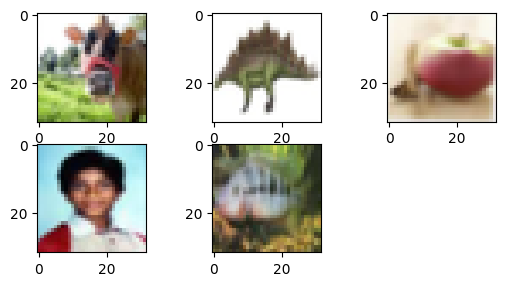

Images with cutout:


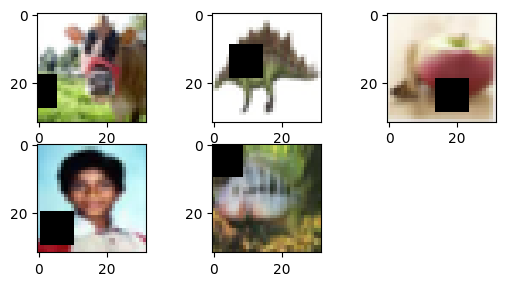

In [55]:
import matplotlib.pyplot as plt
print("Original images:")
for i in range(5):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()
print("Images with cutout:")
for i in range(5):
    plt.subplot(330 + 1 + i)
    plt.imshow(apply_cutout(x_train[i]))
plt.show()

## Random Erasing Regularization

In [56]:
def random_erasing(image, p=0.5, s=(0.02, 0.4), r=(0.3, 3.3)):
    if np.random.rand() > p: # Return the original image with some probability
        return image

    h, w, _ = image.shape # Get the shape of the image
    area = h * w # Caculate the area of the image

    while True:
        target_area = np.random.uniform(*s) * area
        aspect_ratio = np.random.uniform(*r)
        h_erasing = int(np.sqrt(target_area * aspect_ratio))
        w_erasing = int(np.sqrt(target_area / aspect_ratio))
        left = np.random.randint(0, w)
        top = np.random.randint(0, h)

        if left + w_erasing <= w and top + h_erasing <= h:
            break

    # top:top+h_erasing selects the rows of the image starting from index top up to top+h_erasing.
    # left:left+w_erasing selects the columns of the image starting from index left up to left+w_erasing.
    # : in the third dimension indicates that all color channels are selected.

    # Sets values in a 3d array of random numbers with shape(h_erasing, w_erasing, 3) - here 3 is the number of color channels.
    image[top:top+h_erasing, left:left+w_erasing, :] = np.random.rand(h_erasing, w_erasing, 3) * 255.0

    return image

In [57]:
x_train_random_erasing = np.array([random_erasing(image) for image in x_train_copy])

Original images:


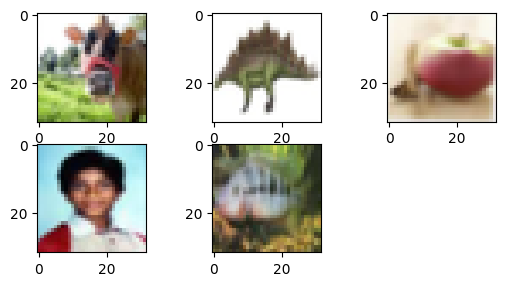

Images with cutout:


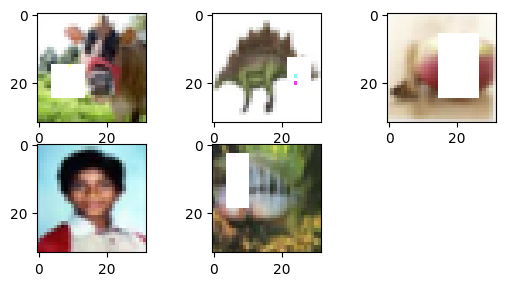

In [59]:
import matplotlib.pyplot as plt
print("Original images:")
for i in range(5):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()
print("Images with cutout:")
for i in range(5):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train_random_erasing[i])
plt.show()

## Model

In [60]:
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model.add(Flatten())
model.add(Dense(256, activation='relu'))

# Block 5
model.add(Dense(100, activation='softmax'))

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 128)        

### Cutout Model Training

In [61]:
#Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Train the model
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train_cutout, y_train, epochs=40, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])
#save loss & validation loss every
train_loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 11s 6ms/step - loss: 4.1488 - accuracy: 0.0528 - val_loss: 3.7772 - val_accuracy: 0.1065
Epoch 2/40
1563/1563 [==============================] - 8s 5ms/step - loss: 3.5522 - accuracy: 0.1440 - val_loss: 3.3299 - val_accuracy: 0.1839
Epoch 3/40
1563/1563 [==============================] - 8s 5ms/step - loss: 3.1751 - accuracy: 0.2140 - val_loss: 3.0423 - val_accuracy: 0.2421
Epoch 4/40
1563/1563 [==============================] - 8s 5ms/step - loss: 2.9157 - accuracy: 0.2653 - val_loss: 3.0076 - val_accuracy: 0.2514
Epoch 5/40
1563/1563 [==============================] - 8s 5ms/step - loss: 2.7063 - accuracy: 0.3040 - val_loss: 2.7481 - val_accuracy: 0.3070
Epoch 6/40
1563/1563 [==============================] - 8s 5ms/step - loss: 2.5180 - accuracy: 0.3438 - val_loss: 2.6712 - val_accuracy: 0.3202
Epoch 7/40
1563/1563 [==============================] - 8s 5ms/step - loss: 2.3697 - accuracy: 0.3731 - val_loss: 2.6346 - val_accuracy: 0.3374
Ep

In [62]:
#Evaluate the model
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 5.5791 - accuracy: 0.3193 - 637ms/epoch - 2ms/step

Test accuracy: 0.31929999589920044


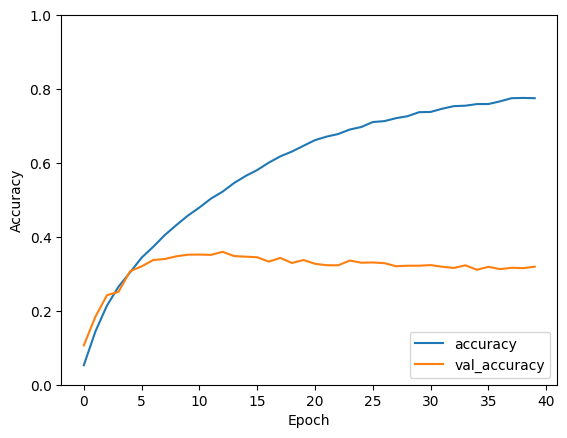

In [63]:
#Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

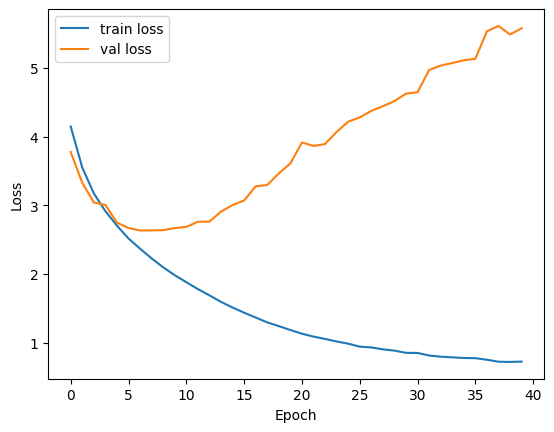

In [64]:
#plot loss
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label = 'val loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
#legend
plt.legend(loc='upper left')
#show plot
plt.show()

In [65]:
#save the trained model (Parameters) so I can use it again without training again
model.save('cifar100_cnn_cutout.h5')
#save the trained model (Weights) so I can use it again without training again
model.save_weights('cifar100_cnn_weights_cutout.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Sample of class to superclass mapping: {19: 11, 29: 15, 0: 4, 11: 14, 1: 1}
313/313 [==============================] - 1s 2ms/step


<Figure size 1000x1000 with 0 Axes>

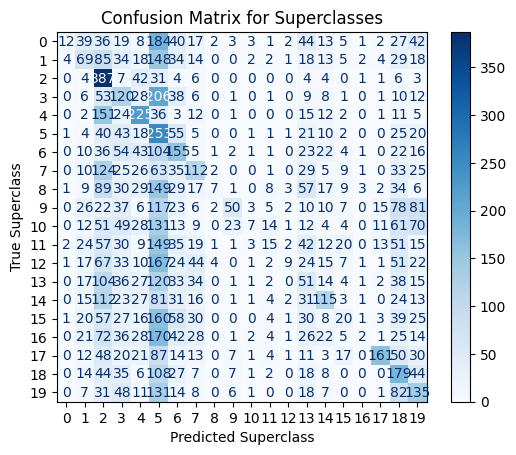

In [66]:
## CONFUSION MATRIX
# Load both fine and coarse labels
(x_train_fine, y_train_fine), (x_test_fine, y_test_fine) = cifar100.load_data(label_mode='fine')
(x_train_coarse, y_train_coarse), (x_test_coarse, y_test_coarse) = cifar100.load_data(label_mode='coarse')

# Establish a mapping from fine labels to coarse labels
class_to_superclass = {}
for fine, coarse in zip(y_train_fine.flatten(), y_train_coarse.flatten()):
    if fine not in class_to_superclass:
        class_to_superclass[fine] = coarse

# Optional: Check the mapping (for understanding/debugging)
print("Sample of class to superclass mapping:", {k: class_to_superclass[k] for k in list(class_to_superclass)[:5]})

# Predict the classes using the trained model
y_pred = model.predict(x_test_fine)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_super = np.vectorize(class_to_superclass.get)(y_pred_classes)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix for superclasses
cm_super = confusion_matrix(y_test_coarse, y_pred_super)

# Display the confusion matrix
plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_super)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Superclasses')
plt.xlabel('Predicted Superclass')
plt.ylabel('True Superclass')
plt.show()

### Random Erasing Training

In [67]:
#Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Train the model
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train_random_erasing, y_train, epochs=40, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])
#save loss & validation loss every
train_loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 11s 6ms/step - loss: 23.4986 - accuracy: 0.1735 - val_loss: 3.5853 - val_accuracy: 0.2900
Epoch 2/40
1563/1563 [==============================] - 8s 5ms/step - loss: 3.0872 - accuracy: 0.2874 - val_loss: 3.7849 - val_accuracy: 0.3157
Epoch 3/40
1563/1563 [==============================] - 8s 5ms/step - loss: 2.8921 - accuracy: 0.3339 - val_loss: 4.0581 - val_accuracy: 0.3238
Epoch 4/40
1563/1563 [==============================] - 8s 5ms/step - loss: 2.8171 - accuracy: 0.3532 - val_loss: 4.0628 - val_accuracy: 0.3144
Epoch 5/40
1563/1563 [==============================] - 8s 5ms/step - loss: 2.9345 - accuracy: 0.3280 - val_loss: 4.0342 - val_accuracy: 0.3094
Epoch 6/40
1563/1563 [==============================] - 8s 5ms/step - loss: 2.8487 - accuracy: 0.3423 - val_loss: 4.2828 - val_accuracy: 0.3121
Epoch 7/40
1563/1563 [==============================] - 8s 5ms/step - loss: 2.8880 - accuracy: 0.3326 - val_loss: 4.1883 - val_accuracy: 0.3033
E

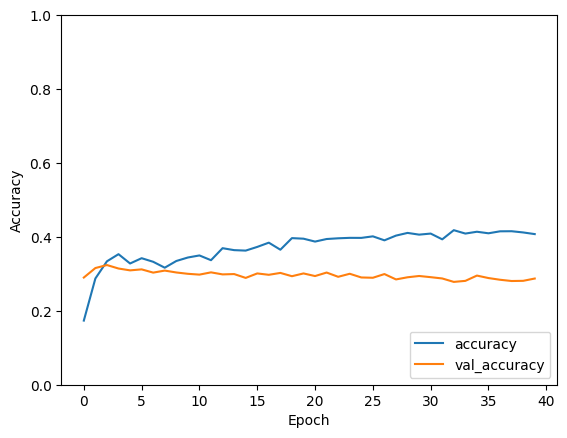

In [68]:
#Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

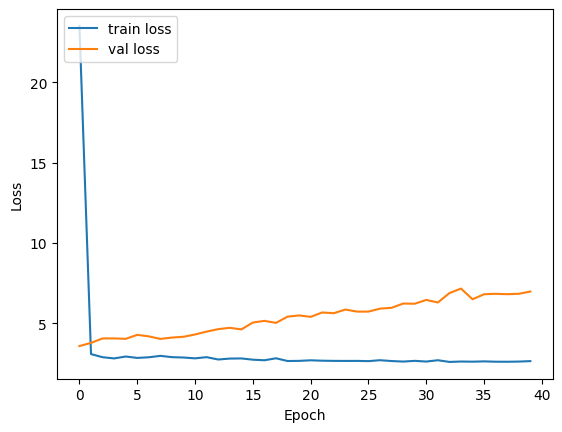

In [69]:
#plot loss
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label = 'val loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
#legend
plt.legend(loc='upper left')
#show plot
plt.show()

Sample of class to superclass mapping: {19: 11, 29: 15, 0: 4, 11: 14, 1: 1}
313/313 [==============================] - 1s 2ms/step


<Figure size 1000x1000 with 0 Axes>

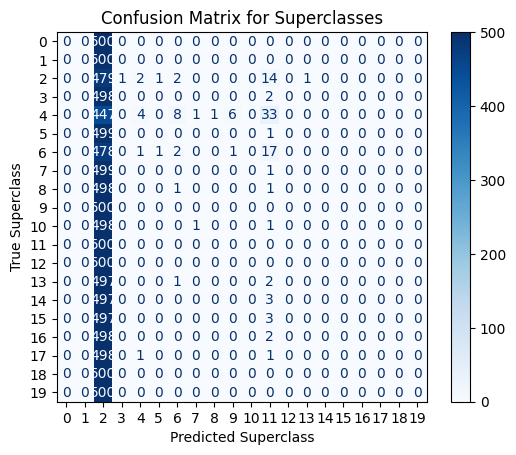

In [70]:
## CONFUSION MATRIX
# Load both fine and coarse labels
(x_train_fine, y_train_fine), (x_test_fine, y_test_fine) = cifar100.load_data(label_mode='fine')
(x_train_coarse, y_train_coarse), (x_test_coarse, y_test_coarse) = cifar100.load_data(label_mode='coarse')

# Establish a mapping from fine labels to coarse labels
class_to_superclass = {}
for fine, coarse in zip(y_train_fine.flatten(), y_train_coarse.flatten()):
    if fine not in class_to_superclass:
        class_to_superclass[fine] = coarse

# Optional: Check the mapping (for understanding/debugging)
print("Sample of class to superclass mapping:", {k: class_to_superclass[k] for k in list(class_to_superclass)[:5]})

# Predict the classes using the trained model
y_pred = model.predict(x_test_fine)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_super = np.vectorize(class_to_superclass.get)(y_pred_classes)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix for superclasses
cm_super = confusion_matrix(y_test_coarse, y_pred_super)

# Display the confusion matrix
plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_super)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Superclasses')
plt.xlabel('Predicted Superclass')
plt.ylabel('True Superclass')
plt.show()

In [71]:
#save the trained model (Parameters) so I can use it again without training again
model.save('cifar100_cnn_random_erasing.h5')
#save the trained model (Weights) so I can use it again without training again
model.save_weights('cifar100_cnn_weights_random_erasing.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
